In [1]:
from sklearn.linear_model import Perceptron
from sklearn import model_selection,metrics, preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import random
import torch
from torch import nn, optim
import math
from IPython import display

In [4]:
df=pd.read_csv('diabetes.csv')
df.head()

,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,Myocardial,PhysActivity,Fruit,Vegetables,...,NotAbleToAffordDoctor,GeneralHealth,MentalHealth,PhysicalHealth,HardToClimbStairs,BiologicalSex,AgeBracket,EducationBracket,IncomeBracket,Zodiac
0,0,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,1,9,4,3,10
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,1,7,6,1,11
2,0,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,1,9,4,8,2
3,0,1,0,27,0,0,0,1,1,1,...,0,2,0,0,0,1,11,3,6,11
4,0,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,1,11,5,4,8


In [5]:
X=df.loc[:,'HighBP':'Zodiac']
print(X.shape)
X.head()

(253680, 21)


,HighBP,HighChol,BMI,Smoker,Stroke,Myocardial,PhysActivity,Fruit,Vegetables,HeavyDrinker,...,NotAbleToAffordDoctor,GeneralHealth,MentalHealth,PhysicalHealth,HardToClimbStairs,BiologicalSex,AgeBracket,EducationBracket,IncomeBracket,Zodiac
0,1,1,40,1,0,0,0,0,1,0,...,0,5,18,15,1,1,9,4,3,10
1,0,0,25,1,0,0,1,0,0,0,...,1,3,0,0,0,1,7,6,1,11
2,1,1,28,0,0,0,0,1,0,0,...,1,5,30,30,1,1,9,4,8,2
3,1,0,27,0,0,0,1,1,1,0,...,0,2,0,0,0,1,11,3,6,11
4,1,1,24,0,0,0,1,1,1,0,...,0,2,3,0,0,1,11,5,4,8


In [6]:
y=df['Diabetes']
y.head()
print(y.shape)

(253680,)


In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size = 0.2)
print(X_test.shape)
print(y_test.shape)

(50736, 21)
(50736,)


Perceptron

In [10]:
clf = Perceptron(tol=1e-3, random_state=0, shuffle=True)
mean = X.mean(axis=0)
std = X.std(axis=0)
X_train_norm = (X_train - mean) / std
X_test_norm = (X_test - mean) / std
clf.fit(X_train_norm,y_train)
AUROC = metrics.roc_auc_score(y_test, clf.decision_function(X_test))
print(AUROC)

0.678476701371747


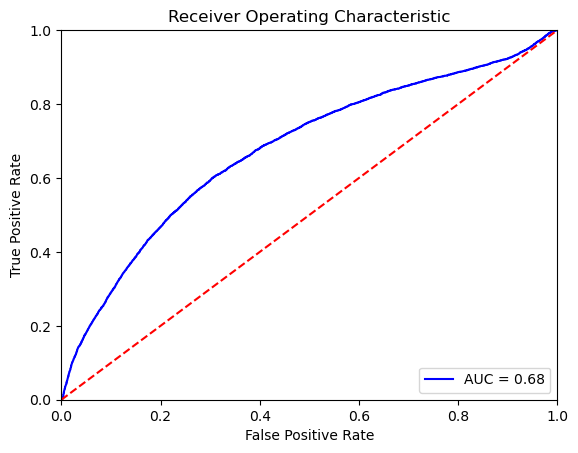

In [11]:
preds = clf.decision_function(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Neural Network

In [112]:
D = 21  # input dimensions
C = 2  # num_classes
H = 30  # num_hidden_units

learning_rate = 1e-2
lambda_l2 = 1e-1 

model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, H),
    nn.Linear(H, C)
)
print(model)

Sequential(
  (0): Linear(in_features=21, out_features=30, bias=True)
  (1): Linear(in_features=30, out_features=30, bias=True)
  (2): Linear(in_features=30, out_features=2, bias=True)
)


In [113]:
scaler = preprocessing.StandardScaler()
X_train_pth = torch.tensor(scaler.fit_transform(X_train_norm), dtype=torch.float32)
y_train_pth = torch.tensor(y_train.values).long()
X_test_pth = torch.tensor(scaler.fit_transform(X_test_norm), dtype=torch.float32)
y_test_pth = torch.tensor(y_test.values).long()
print(X_train_pth.shape,y_train_pth.shape, X_test_pth.shape, y_test_pth)

torch.Size([202944, 21]) torch.Size([202944]) torch.Size([50736, 21]) tensor([0, 0, 0,  ..., 0, 0, 0])


In [114]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) 

for t in range(1000):
    y_pred = model(X_train_pth) 
    loss = criterion(y_pred, y_train_pth) 
    score, predicted = torch.max(y_pred, 1)
    acc = (y_train_pth == predicted).sum() / len(y_train)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 

[EPOCH]: 999, [LOSS]: 0.350651, [ACCURACY]: 0.862


In [115]:
y_pred=model(X_test_pth)
auroc = metrics.roc_auc_score(y_test, y_pred[:,1].detach().numpy())
print(auroc)

0.812007912008042


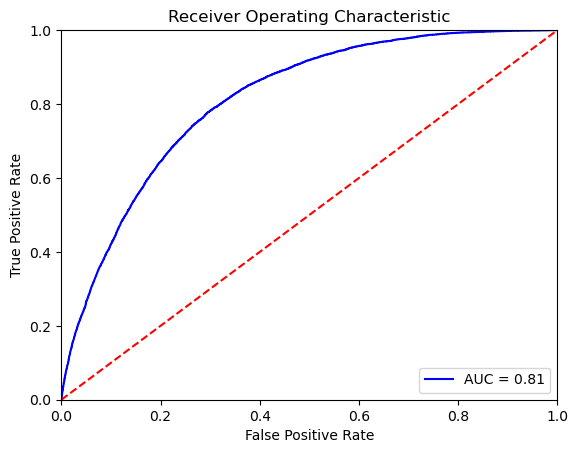

In [116]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred[:,1].detach().numpy())
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

BMI

In [118]:
X1=df.loc[:,df.columns != 'BMI']
X1_norm=(X1-X1.mean(axis=0))/X1.std(axis=0)

In [119]:
y1_norm=(df['BMI']-df['BMI'].mean())/df['BMI'].std()

In [120]:
X_train1, X_test1, y_train1, y_test1 = model_selection.train_test_split(X1_norm,y1_norm, test_size = 0.4)

In [121]:
D = 21  # input dimensions
C = 1  
H = 30  # num_hidden_units

learning_rate = 1e-2
lambda_l2 = 1e-1 

model1 = nn.Sequential(
    nn.Linear(D, H),
    nn.Sigmoid(),
    nn.Linear(H, C)
)
print(model1)

Sequential(
  (0): Linear(in_features=21, out_features=30, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=30, out_features=1, bias=True)
)


In [122]:
scaler = preprocessing.StandardScaler()
X_train_pth1 = torch.tensor(scaler.fit_transform(X_train1), dtype=torch.float32)
y_train_pth1 = torch.tensor(y_train1.values).float()
X_test_pth1 = torch.tensor(scaler.fit_transform(X_test1), dtype=torch.float32)
y_test_pth1 = torch.tensor(y_test1.values).float()
print(X_train_pth1.shape,y_train_pth1.shape, X_test_pth1.shape, y_test_pth1.shape)

torch.Size([152208, 21]) torch.Size([152208]) torch.Size([101472, 21]) torch.Size([101472])


In [123]:
criterion = nn.MSELoss()

optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate, weight_decay=lambda_l2) 

batch_size = int(len(X_train_pth1)/9)

for epoch in range(100):
    for i in range(0, len(X_train_pth1), batch_size):
        batch_X = X_train_pth1[i:i+batch_size]
        batch_y = y_train_pth1[i:i+batch_size]
        y_pred1 = model1(batch_X) 
        loss = criterion(y_pred1, batch_y)
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 

In [124]:
batch_size1=int(len(X_test_pth1)/9)
sum_squared_error = 0.0
total_samples = 0

with torch.no_grad():
    for i in range(0, len(X_test_pth1), batch_size1):
        batch_X1 = X_test_pth1[i:i+batch_size1]
        batch_y1 = y_test_pth1[i:i+batch_size1]
        
        # Forward pass
        outputs = model1(batch_X1)
        
        # Compute squared error
        batch_squared_error = torch.sum((outputs - batch_y1)**2).item()
        
        # Accumulate sum of squared errors and total samples
        sum_squared_error += batch_squared_error
        total_samples += len(batch_X1)

mean_squared_error = sum_squared_error / total_samples

# Calculate RMSE
test_rmse = math.sqrt(mean_squared_error)
print(test_rmse)

106.07306829327857


BMI Model 2

In [43]:
D = 21  # input dimensions
C = 1  
H = 20  # num_hidden_units

learning_rate = 1e-4
lambda_l2 = 1e-1 

model2 = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
print(model2)

Sequential(
  (0): Linear(in_features=21, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=1, bias=True)
)


In [44]:
criterion = nn.MSELoss()

optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate, weight_decay=lambda_l2) 

batch_size = int(len(X_train_pth1)/9)

for epoch in range(50):
    for i in range(0, len(X_train_pth1), batch_size):
        batch_X = X_train_pth1[i:i+batch_size]
        batch_y = y_train_pth1[i:i+batch_size]
        y_pred1 = model2(batch_X) 
        loss = criterion(y_pred1, batch_y)
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 

In [45]:
batch_size1=int(len(X_test_pth1)/9)
sum_squared_error = 0.0
total_samples = 0

with torch.no_grad():
    for i in range(0, len(X_test_pth1), batch_size1):
        batch_X1 = X_test_pth1[i:i+batch_size1]
        batch_y1 = y_test_pth1[i:i+batch_size1]
        
        # Forward pass
        outputs = model2(batch_X1)
        
        # Compute squared error
        batch_squared_error = torch.sum((outputs - batch_y1)**2).item()
        
        # Accumulate sum of squared errors and total samples
        sum_squared_error += batch_squared_error
        total_samples += len(batch_X1)

mean_squared_error = sum_squared_error / total_samples

# Calculate RMSE
test_rmse = math.sqrt(mean_squared_error)
print(test_rmse)

106.43463717677508
